# Homework 2

- [homework](https://github.com/alexkolo/ml-zoomcamp-2024/blob/main/cohorts/2024/02-regression/homework.md)
- [submit here](https://courses.datatalks.club/ml-zoomcamp-2024/homework/hw02)
    - Due date: 8 October 2024 01:00 (local time)
    - [link to notebook](https://github.com/alexkolo/ml-zoomcamp-2024/blob/main/cohorts/2024/02-regression/hw02_my_answers.ipynb)

### Dataset

In [1]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

### Preparing the dataset 

First, we'll normalize the names of the columns:

```python
df.columns = df.columns.str.lower().str.replace(' ', '_')
```

Now, instead of `'Final Price'`, we have `'final_price'`.

Next, use only the following columns:

* `'ram'`,
* `'storage'`,
* `'screen'`,
* `'final_price'`

In [2]:
import pandas as pd

cols = ["ram", "storage", "screen", "final_price"]
df = pd.read_csv("laptops.csv")
df.columns = df.columns.str.lower().str.replace(" ", "_")
df = df[cols]
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


### EDA

* Look at the `final_price` variable. Does it have a long tail? 

#### Answer

yes, towards high prices

<Axes: >

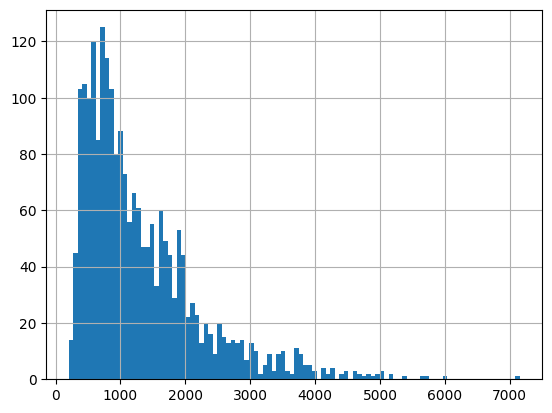

In [3]:
df["final_price"].hist(bins=100)

### Question 1

There's one column with missing values. What is it?

* `'ram'`
* `'storage'`
* `'screen'`
* `'final_price'`

#### Answer

`'screen'`

In [4]:
# show columns with missing values
df.columns[df.isna().sum() > 0].to_list()

['screen']

### Question 2

What's the median (50% percentile) for variable `'ram'`?

- 8
- 16
- 24
- 32

#### Answer

`16`

In [5]:
df["ram"].median()

np.float64(16.0)


### Prepare and split the dataset

* Shuffle the dataset (the filtered one you created above), use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.

Use the same code as in the lectures

In [6]:
import numpy as np


def split_data(
    df: pd.DataFrame, target: str, seed: int, f_val: float, f_test: float, na_fill=np.nan
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    n = len(df)
    n_val = int(n * f_val)
    n_test = int(n * f_test)
    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train : n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val :]]

    df_train = df_train.reset_index(drop=True).fillna(na_fill)
    df_val = df_val.reset_index(drop=True).fillna(na_fill)
    df_test = df_test.reset_index(drop=True).fillna(na_fill)

    # y_train = np.log1p(df_train[target].values)
    # y_val = np.log1p(df_val[target].values)
    # y_test = np.log1p(df_test[target].values)
    y_train = df_train[target].values
    y_val = df_val[target].values
    y_test = df_test[target].values

    del df_train[target]
    del df_val[target]
    del df_test[target]

    return {
        "df_train": df_train,
        "df_val": df_val,
        "df_test": df_test,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test,
    }


# print(df_train.shape, df_val.shape, df_test.shape)

In [37]:
# Parameters
seed = 42
f_val = 0.2
f_test = 0.2
target = "final_price"
splitted_data = split_data(df, target=target, seed=seed, f_val=f_val, f_test=f_test)

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

Options:

- With 0
- With mean
- Both are equally good


#### Answer

With 0

In [8]:
def train_linear_regression(X: np.ndarray, y: np.ndarray) -> tuple[float, np.ndarray]:
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [28]:
def compute_rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [39]:
# Parameters
seed = 42
f_val = 0.2
f_test = 0.2
target = "final_price"
splitted_data = split_data(df, target=target, seed=seed, f_val=f_val, f_test=f_test)
df_train = splitted_data["df_train"]
df_val = splitted_data["df_val"]
y_train = splitted_data["y_train"]
y_val = splitted_data["y_val"]

In [40]:
fill_values: dict[str, float] = {"mean": df_train["screen"].mean(), "zero": 0.0}
for name, fill in fill_values.items():
    X_train = df_train.fillna(fill).values

    w0, w = train_linear_regression(X_train, y_train)

    # test
    X_val = df_val.fillna(fill).values
    y_pred = w0 + X_val.dot(w)

    # Compute RMSE
    rmse = compute_rmse(y_val, y_pred)  # np.sqrt(np.square(y_pred - y_val).mean())

    print(f"{name}: rmse={round(rmse,2)}, fill={fill:2.2g}, w0={w0:.2}, w={w}")


mean: rmse=600.27, fill=15, w0=8.1e+02, w=[ 43.90774584   0.87135236 -45.18273312]
zero: rmse=597.36, fill= 0, w0=6.8e+02, w=[ 43.70681555   0.86506867 -36.10399833]


### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

Options:

- 0
- 0.01
- 1
- 10
- 100

#### Answer

- `10`

In [14]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [42]:
# Parameters
seed = 42
f_val = 0.2
f_test = 0.2
target = "final_price"
splitted_data = split_data(df, target=target, seed=seed, f_val=f_val, f_test=f_test, na_fill=0)
X_train = splitted_data["df_train"].values
X_val = splitted_data["df_val"].values
y_train = splitted_data["y_train"]
y_val = splitted_data["y_val"]

In [43]:
res = {}
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    # Compute RMSE
    y_pred = w0 + X_val.dot(w)
    res[r] = compute_rmse(y_val, y_pred)

In [44]:
pd.Series(res).round(2).sort_values(ascending=True)

5.00      597.01
10.00     597.06
1.00      597.21
0.10      597.35
0.00      597.36
0.01      597.36
100.00    597.90
dtype: float64

### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

- 19.176
- 29.176
- 39.176
- 49.176

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.


#### Answer

closest to `29.176`

In [45]:
f_val = 0.2
f_test = 0.2
target = "final_price"
res = {}
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    data = split_data(
        df,
        target=target,
        seed=seed,
        f_val=f_val,
        f_test=f_test,
        na_fill=0,
    )

    # fit
    X_train = data["df_train"].values
    y_train = data["y_train"]
    w0, w = train_linear_regression(X_train, y_train)

    # Compute RMSE
    X_val = data["df_val"].values
    y_val = data["y_val"]
    y_pred = w0 + X_val.dot(w)
    res[seed] = compute_rmse(y_val, y_pred)

In [46]:
pd.Series(res).std().round(3)

np.float64(30.755)

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:

- 598.60
- 608.60
- 618.60
- 628.60

#### Answer

`608.60`

In [47]:
r = 0.001
seed = 9

f_val = 0.2
f_test = 0.2
target = "final_price"
data = split_data(
    df,
    target=target,
    seed=seed,
    f_val=f_val,
    f_test=f_test,
    na_fill=0,
)

# fit
X_train = data["df_train"].values
y_train = data["y_train"]
X_val = data["df_val"].values
y_val = data["y_val"]

x_all = np.concatenate([X_train, X_val])
y_all = np.concatenate([y_train, y_val])
w0, w = train_linear_regression_reg(x_all, y_all, r=r)

# test
X_test = data["df_test"].values
y_test = data["y_test"]
y_pred = w0 + X_test.dot(w)
rmse = np.sqrt(np.square(y_pred - y_test).mean())
round(rmse, 2)

np.float64(608.61)